In [1]:
using QuantEcon
using BasisMatrices
using ContinuousDPs
using Plots
import PyPlot

## Optimal Economic Growth

In [2]:
n = 10
s_min, s_max = 5, 10
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb


In [3]:
alpha = 0.2
bet = 0.5
gamm = 0.9
sigma = 0.1
discount = 0.9;

In [4]:
x_star = ((discount * bet) / (1 - discount * gamm))^(1 / (1 - bet))
s_star = gamm * x_star + x_star^bet
s_star, x_star

(7.416897506925212, 5.6094182825484795)

In [5]:
f(s, x) = (s - x)^(1 - alpha) / (1 - alpha)
g(s, x, e) = gamm * x + e * x^bet;

In [6]:
n_shocks = 3
shocks, weights = qnwlogn(n_shocks, -sigma^2/2, sigma^2)  # See Errata

([0.836771, 0.995012, 1.18318], [0.166667, 0.666667, 0.166667])

In [7]:
x_lb(s) = 0
x_ub(s) = 0.99 * s;

In [8]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDPs.ContinuousDP{1,1}(f, g, 0.9, [0.836771, 0.995012, 1.18318], [0.166667, 0.666667, 0.166667], x_lb, x_ub, ContinuousDPs.Interp{1,Array{Float64,1},Array{Float64,2},Base.LinAlg.LU{Float64,Array{Float64,2}}}(1 dimensional Basis on the hypercube formed by (5.0,) × (10.0,).
Basis families are Cheb
, [5.03078, 5.27248, 5.73223, 6.36502, 7.10891, 7.89109, 8.63498, 9.26777, 9.72752, 9.96922], ([5.03078, 5.27248, 5.73223, 6.36502, 7.10891, 7.89109, 8.63498, 9.26777, 9.72752, 9.96922],), 10, (10,), (5.0,), (10.0,), [1.0 -0.987688 … 0.309017 -0.156434; 1.0 -0.891007 … -0.809017 0.45399; … ; 1.0 0.891007 … -0.809017 -0.45399; 1.0 0.987688 … 0.309017 0.156434], Base.LinAlg.LU{Float64,Array{Float64,2}} with factors L and U:
[1.0 0.0 … 0.0 0.0; 1.0 1.0 … 0.0 0.0; … ; 1.0 0.0489435 … 1.0 0.0; 1.0 0.579192 … -0.45965 1.0]
[1.0 -0.987688 … 0.309017 -0.156434; 0.0 1.97538 … -1.4877e-14 0.312869; … ; 0.0 0.0 … -5.25731 1.64485; 0.0 0.0 … 0.0 5.06233]))

### Value iteration

In [9]:
res = solve(cdp, VFI);

Compute iterate 50 with error 0.008569366466243622
Compute iterate 100 with error 4.4164588459238985e-5
Compute iterate 150 with error 2.2761436468954344e-7
Compute iterate 176 with error 1.4706344586556952e-8
Converged in 176 steps


In [10]:
s_min, s_max = cdp.interp.lb[1], cdp.interp.ub[1]
grid_length = 500
s_nodes = linspace(s_min, s_max, grid_length)
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;


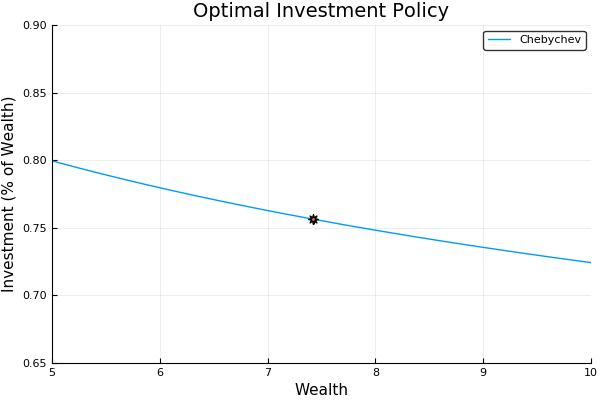

In [11]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(s_nodes, X./s_nodes, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")


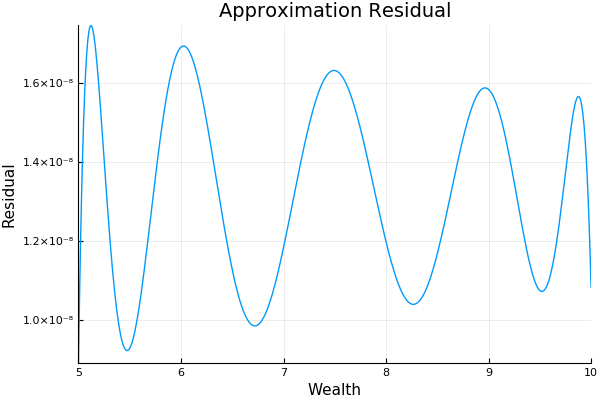

In [12]:
title = "Approximation Residual"
ylabel = "Residual"
plot(s_nodes, resid, xlims=(s_min, s_max), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Policy iteration

In [13]:
res = solve(cdp, PFI);

Compute iterate 6 with error 1.4210854715202004e-14
Converged in 6 steps


In [14]:
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;


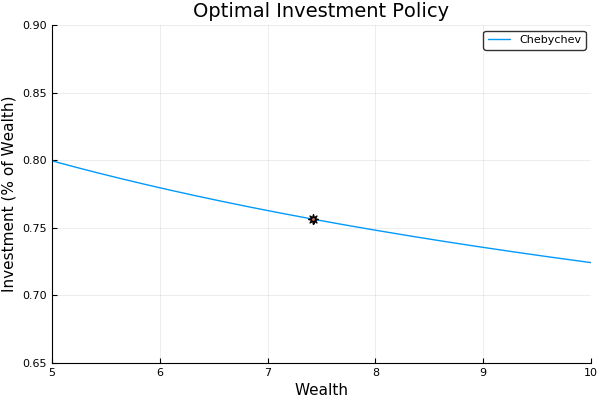

In [15]:
title = "Optimal Investment Policy"
xlabel = "Wealth"
ylabel = "Investment (% of Wealth)"
plot(s_nodes, X./s_nodes, xlims=(s_min, s_max), ylims=(0.65, 0.9),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Chebychev")
plot!([s_star], [x_star/s_star], m=(7,:star8), label="")


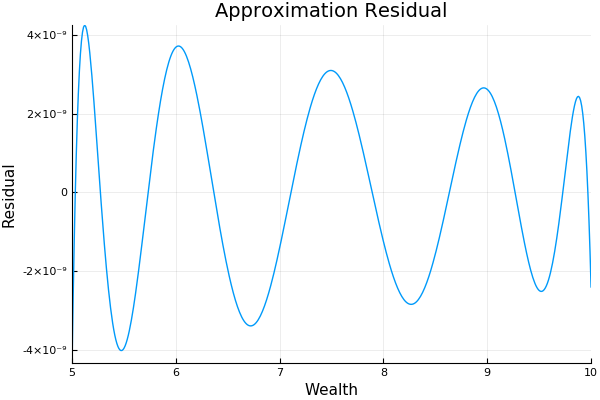

In [16]:
title = "Approximation Residual"
ylabel = "Residual"
plot(s_nodes, resid, xlims=(s_min, s_max), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Simulation

In [17]:
n_yrs = 20
n_paths = 2000
s_paths = Array{Float64}(n_yrs+1, n_paths)
s_init = 5.
for i in 1:n_paths
    s_paths[:, i] = simulate(res, s_init, n_yrs+1)
end
mean_s_path = mean(s_paths, 2);


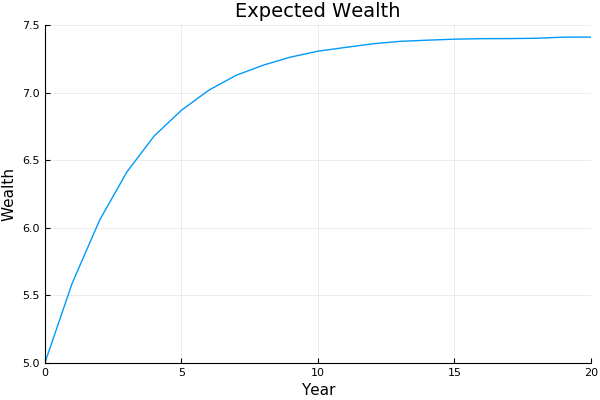

In [18]:
title = "Expected Wealth"
xlabel = "Year"
ylabel = "Wealth"
plot(0:n_yrs, mean_s_path, ylims=(5, 7.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

## Nonrenewable Resource Management

In [19]:
k = 3
m = 101
breaks = m - (k-1)
s_min, s_max = 0, 10
basis = Basis(SplineParams(breaks, s_min, s_max, k))

1 dimensional Basis on the hypercube formed by (0.0,) × (10.0,).
Basis families are Spline


In [20]:
a = [10, 0.8]
b = [12, 1.0]
discount = 0.9;

In [21]:
p(x) = a[1] - a[2] * x / 2
c(s, x) = b[1] * x - b[2] * x * (2*s - x) / 2
f(s, x) = p(x) * x - c(s, x)
g(s, x, e) = s - x;

In [22]:
shocks, weights = [0.], [1.];

In [23]:
x_lb(s) = 0
x_ub(s) = s;

In [24]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDPs.ContinuousDP{1,1}(f, g, 0.9, [0.0], [1.0], x_lb, x_ub, ContinuousDPs.Interp{1,Array{Float64,1},SparseMatrixCSC{Float64,Int64},Base.SparseArrays.UMFPACK.UmfpackLU{Float64,Int64}}(1 dimensional Basis on the hypercube formed by (0.0,) × (10.0,).
Basis families are Spline
, [0.0, 0.0340136, 0.102041, 0.204082, 0.306122, 0.408163, 0.510204, 0.612245, 0.714286, 0.816327  …  9.18367, 9.28571, 9.38776, 9.4898, 9.59184, 9.69388, 9.79592, 9.89796, 9.96599, 10.0], ([0.0, 0.0340136, 0.102041, 0.204082, 0.306122, 0.408163, 0.510204, 0.612245, 0.714286, 0.816327  …  9.18367, 9.28571, 9.38776, 9.4898, 9.59184, 9.69388, 9.79592, 9.89796, 9.96599, 10.0],), 101, (101,), (0.0,), (10.0,), 
  [1  ,   1]  =  1.0
  [2  ,   1]  =  0.296296
  [1  ,   2]  =  0.0
  [2  ,   2]  =  0.564815
  [3  ,   2]  =  0.25
  [1  ,   3]  =  0.0
  [2  ,   3]  =  0.132716
  [3  ,   3]  =  0.583333
  [4  ,   3]  =  0.166667
  [1  ,   4]  =  0.0
  ⋮
  [98 ,  99]  =  0.166667
  [99 ,  99]  =  0.583333
  [100,  99]  =

### Value iteration

In [25]:
res = solve(cdp, VFI);

Compute iterate 38 with error 1.4533888759160618e-8
Converged in 38 steps


In [26]:
s_min, s_max = cdp.interp.lb[1], cdp.interp.ub[1]
grid_length = 500
s_nodes = linspace(s_min, s_max, grid_length)
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;


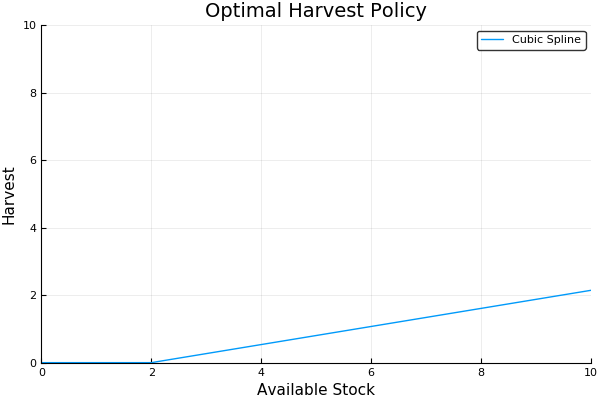

In [27]:
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest"
plot(s_nodes, X, xlims=(s_min, s_max), ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")

In [28]:
B1 = evalbase(cdp.interp.basis.params[1], s_nodes, 1)
shadow_prices = B1 * res.C;


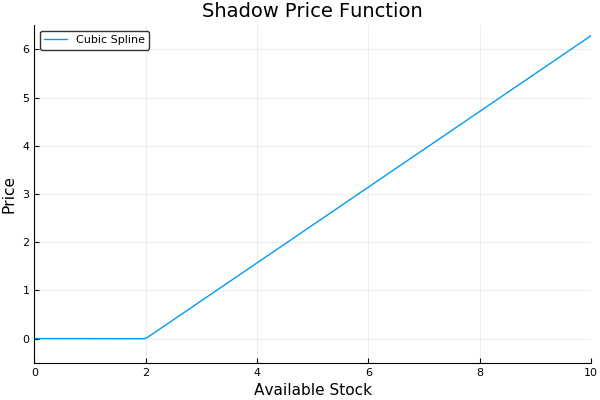

In [29]:
title = "Shadow Price Function"
ylabel = "Price"
plot(s_nodes, shadow_prices, xlims=(s_min, s_max), ylims=(-0.5, 6.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


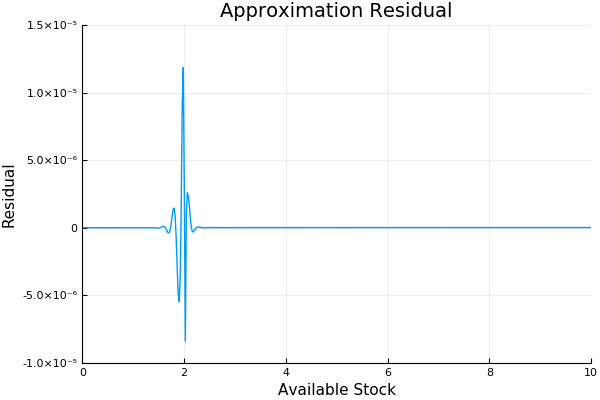

In [30]:
title = "Approximation Residual"
ylabel = "Residual"
plot(s_nodes, resid, xlims=(s_min, s_max), ylims=(-1e-5, 1.5e-5), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Policy iteration

In [31]:
res = solve(cdp, PFI);

Compute iterate 6 with error 2.842170943040401e-14
Converged in 6 steps


In [32]:
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;


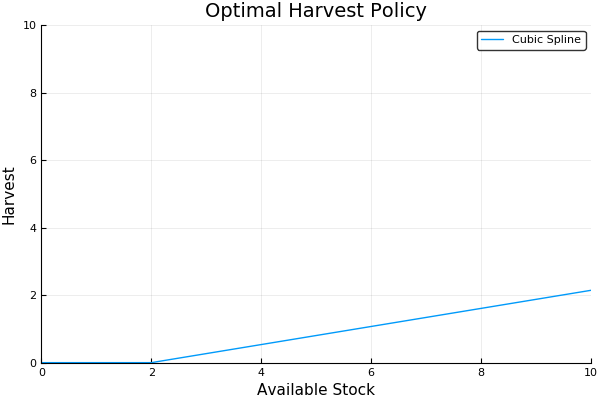

In [33]:
title = "Optimal Harvest Policy"
xlabel = "Available Stock"
ylabel = "Harvest"
plot(s_nodes, X, xlims=(s_min, s_max), ylims=(0, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")

In [34]:
B1 = evalbase(cdp.interp.basis.params[1], s_nodes, 1)
shadow_prices = B1 * res.C;


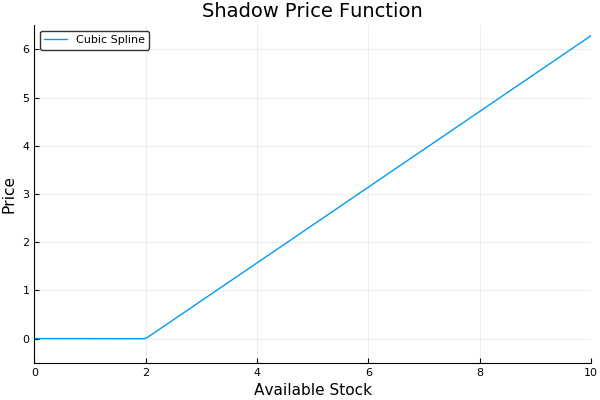

In [35]:
title = "Shadow Price Function"
ylabel = "Price"
plot(s_nodes, shadow_prices, xlims=(s_min, s_max), ylims=(-0.5, 6.5),
     title=title, xlabel=xlabel, ylabel=ylabel, label="Cubic Spline")


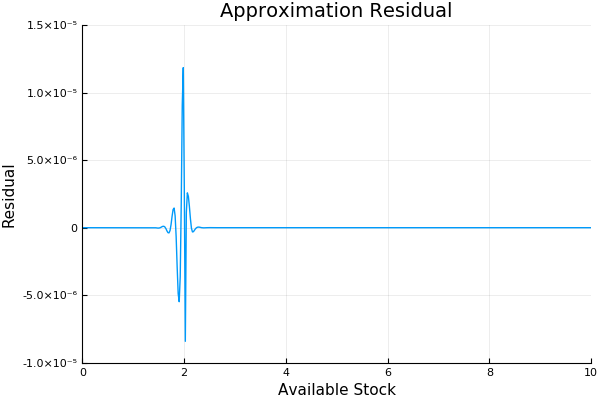

In [36]:
title = "Approximation Residual"
ylabel = "Residual"
plot(s_nodes, resid, xlims=(s_min, s_max), ylims=(-1e-5, 1.5e-5), yformatter=:scientific,
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

### Simulation

In [37]:
n_yrs = 20
s_init = 10.
s_path = simulate(res, s_init, n_yrs+1);


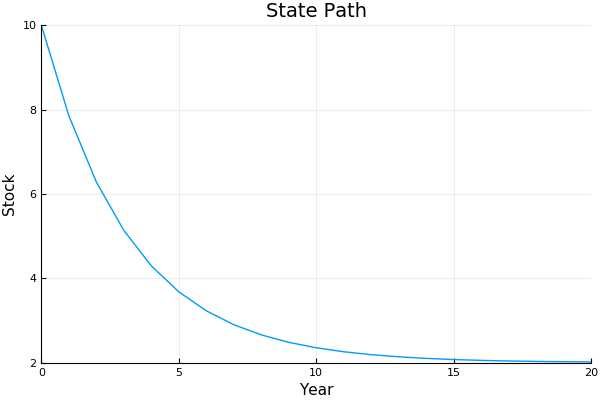

In [38]:
title = "State Path"
xlabel = "Year"
ylabel = "Stock"
plot(0:n_yrs, s_path, ylims=(2, 10),
     title=title, xlabel=xlabel, ylabel=ylabel, label="")

## Monetary Policy

In [39]:
bet = [0.8 0.5; 0.2 0.6]
gamm = [-0.8, 0.0]
Omega = [0.3 0.0; 0.0 1.0]
s_target = [0., 1.]
alpha = [0.9, 0.4]
Sigma = 0.04 * eye(2)
discount = 0.9;

In [40]:
f(s::Vector{Float64}, x::Float64) =
    -(s - s_target)' * Omega * (s - s_target) / 2
g(s::Vector{Float64}, x::Float64, e::Vector{Float64}) =
    alpha + bet * s + gamm * x + e
x_lb(s) = 0.
x_ub(s) = 100;

In [41]:
n_shocks = [3, 3]
mu = [0, 0]
shocks, weights = qnwnorm(n_shocks, mu, Sigma)

([-0.34641 -0.34641; 0.0 -0.34641; … ; 0.0 0.34641; 0.34641 0.34641], [0.0277778, 0.111111, 0.0277778, 0.111111, 0.444444, 0.111111, 0.0277778, 0.111111, 0.0277778])

In [42]:
k = [3, 3]
m = [10, 10]
breaks = m - (k-1)
s_min = [-15, -10]
s_max = [15, 10]
basis = Basis(map(SplineParams, breaks, s_min, s_max, k)...)

2 dimensional Basis on the hypercube formed by (-15.0, -10.0) × (15.0, 10.0).
Basis families are Spline × Spline


In [43]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDPs.ContinuousDP{2,2}(f, g, 0.9, [-0.34641 -0.34641; 0.0 -0.34641; … ; 0.0 0.34641; 0.34641 0.34641], [0.0277778, 0.111111, 0.0277778, 0.111111, 0.444444, 0.111111, 0.0277778, 0.111111, 0.0277778], x_lb, x_ub, ContinuousDPs.Interp{2,Array{Float64,2},SparseMatrixCSC{Float64,Int64},Base.SparseArrays.UMFPACK.UmfpackLU{Float64,Int64}}(2 dimensional Basis on the hypercube formed by (-15.0, -10.0) × (15.0, 10.0).
Basis families are Spline × Spline
, [-15.0 -10.0; -13.5714 -10.0; … ; 13.5714 10.0; 15.0 10.0], ([-15.0, -13.5714, -10.7143, -6.42857, -2.14286, 2.14286, 6.42857, 10.7143, 13.5714, 15.0], [-10.0, -9.04762, -7.14286, -4.28571, -1.42857, 1.42857, 4.28571, 7.14286, 9.04762, 10.0]), 100, (10, 10), (-15.0, -10.0), (15.0, 10.0), 
  [1  ,   1]  =  1.0
  [2  ,   1]  =  0.296296
  [11 ,   1]  =  0.296296
  [12 ,   1]  =  0.0877915
  [1  ,   2]  =  0.0
  [2  ,   2]  =  0.564815
  [3  ,   2]  =  0.25
  [4  ,   2]  =  1.78017e-47
  [11 ,   2]  =  0.0
  [12 ,   2]  =  0.167353
  ⋮
  [

### Value iteration

In [44]:
res = solve(cdp, VFI);

Compute iterate 50 with error 0.0008238938349904856
Compute iterate 100 with error 3.319120764899708e-6
Compute iterate 150 with error 1.710407104837941e-8
Compute iterate 152 with error 1.3854446478944737e-8
Converged in 152 steps


In [45]:
s_min, s_max = cdp.interp.lb, cdp.interp.ub
grid_length = collect(cdp.interp.size) * 5
grids = map(linspace, s_min, s_max, grid_length)
s_nodes = gridmake(grids...)
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;

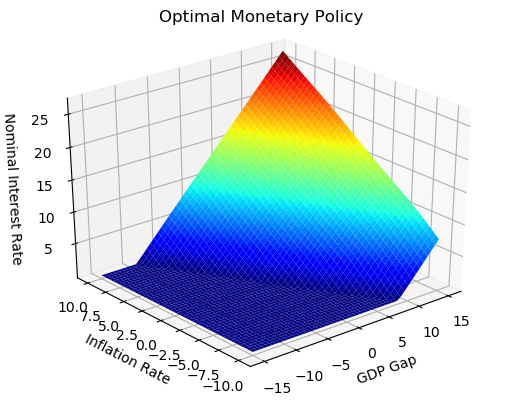

In [46]:
title = "Optimal Monetary Policy"
xlabel = "GDP Gap"
ylabel = "Inflation Rate"
zlabel = "Nominal Interest Rate"
PyPlot.surf(grids..., reshape(X, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

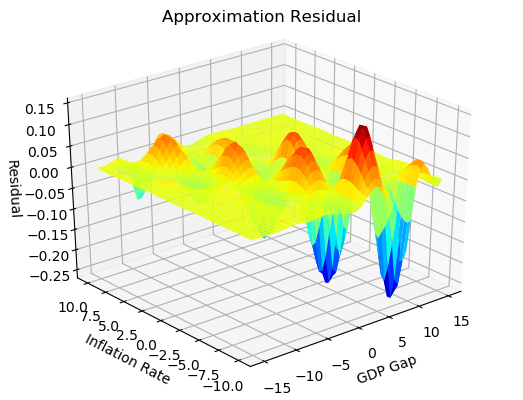

In [47]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., reshape(resid, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

### Policy iteration

In [48]:
res = solve(cdp, PFI);

Compute iterate 9 with error 9.094947017729282e-13
Converged in 9 steps


In [49]:
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;

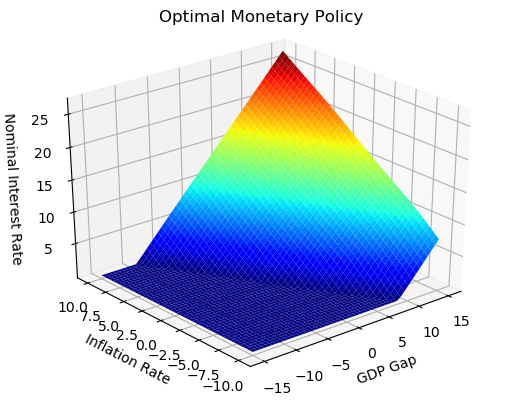

In [50]:
title = "Optimal Monetary Policy"
xlabel = "GDP Gap"
ylabel = "Inflation Rate"
zlabel = "Nominal Interest Rate"
PyPlot.surf(grids..., reshape(X, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

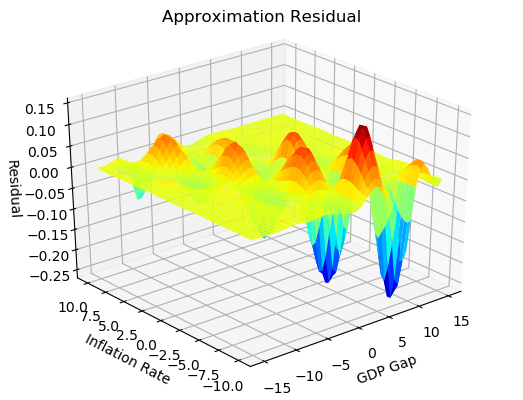

In [51]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., reshape(resid, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

## Production-Adjustment Model

In [52]:
alpha = 0.5
bet = 0.5
kappa = 0.5
sigma = 0.4
discount = 0.9;

In [53]:
prod_cost(q::Float64) = kappa * q
adj_cost(dq::Float64) = 0.5 * alpha * dq^2
f(s::Vector{Float64}, x::Float64) =
    s[1] * x^(1-bet) - prod_cost(x) - adj_cost(x - s[2])
g(s::Vector{Float64}, x::Float64, e::Float64) = [e, x]
x_lb(s) = 0.
x_ub(s) = 100;

In [54]:
n_shocks = 3
shocks, weights = qnwlogn(n_shocks, -sigma^2/2, sigma^2)  # See Errata

([0.461709, 0.923116, 1.84563], [0.166667, 0.666667, 0.166667])

In [55]:
n = [15, 10]
x_star = ((1 - bet) / kappa)^(1/bet)
s_min = [shocks[1], x_star - 1]
s_max = [shocks[end], x_star + 3]
basis = Basis(map(ChebParams, n, s_min, s_max)...)

2 dimensional Basis on the hypercube formed by (0.46170906161702985, 0.0) × (1.8456293363222578, 4.0).
Basis families are Cheb × Cheb


In [56]:
cdp = ContinuousDP(f, g, discount, shocks, weights, x_lb, x_ub, basis)

ContinuousDPs.ContinuousDP{2,1}(f, g, 0.9, [0.461709, 0.923116, 1.84563], [0.166667, 0.666667, 0.166667], x_lb, x_ub, ContinuousDPs.Interp{2,Array{Float64,2},Array{Float64,2},Base.LinAlg.LU{Float64,Array{Float64,2}}}(2 dimensional Basis on the hypercube formed by (0.46170906161702985, 0.0) × (1.8456293363222578, 4.0).
Basis families are Cheb × Cheb
, [0.4655 0.0246233; 0.495576 0.0246233; … ; 1.81176 3.97538; 1.84184 3.97538], ([0.4655, 0.495576, 0.554414, 0.639443, 0.746945, 0.872224, 1.0098, 1.15367, 1.29754, 1.43511, 1.56039, 1.6679, 1.75292, 1.81176, 1.84184], [0.0246233, 0.217987, 0.585786, 1.09202, 1.68713, 2.31287, 2.90798, 3.41421, 3.78201, 3.97538]), 150, (15, 10), (0.46170906161702985, 0.0), (1.8456293363222578, 4.0), [1.0 -0.994522 … 0.0325246 -0.0163519; 1.0 -0.951057 … -0.0919499 0.0483409; … ; 1.0 0.951057 … -0.0919499 -0.0483409; 1.0 0.994522 … 0.0325246 0.0163519], Base.LinAlg.LU{Float64,Array{Float64,2}} with factors L and U:
[1.0 0.0 … 0.0 0.0; 1.0 1.0 … 0.0 0.0; … ; 

### Value iteration

In [57]:
res = solve(cdp, VFI);

Compute iterate 50 with error 0.002979555124706046
Compute iterate 100 with error 1.5355957331486536e-5
Compute iterate 150 with error 7.914115673912647e-8
Compute iterate 166 with error 1.4665010539260948e-8
Converged in 166 steps


In [58]:
s_min, s_max = cdp.interp.lb, cdp.interp.ub
grid_length = collect(cdp.interp.size) * 5
grids = map(linspace, s_min, s_max, grid_length)
s_nodes = gridmake(grids...)
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;

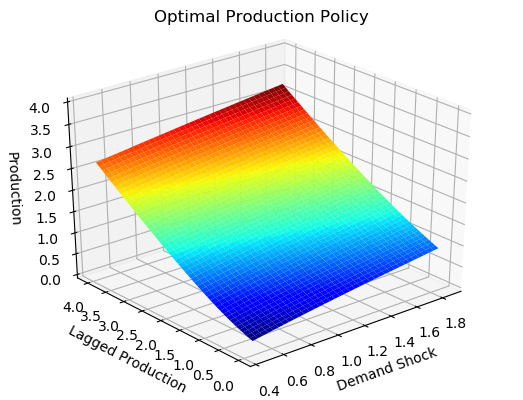

In [59]:
title = "Optimal Production Policy"
xlabel = "Demand Shock"
ylabel = "Lagged Production"
zlabel = "Production"
zlims = (0, 4)
PyPlot.surf(grids..., reshape(X, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_zlim](zlims)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

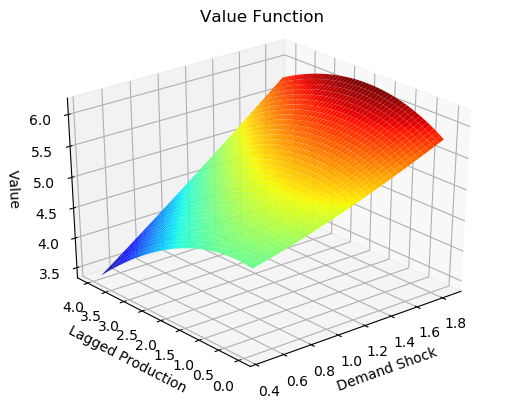

In [60]:
title = "Value Function"
zlabel = "Value"
PyPlot.surf(grids..., reshape(V, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

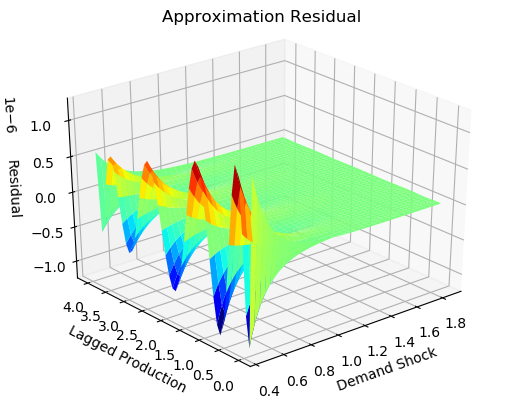

In [61]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., reshape(resid, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)
ax[:ticklabel_format](style="sci", axis="z", scilimits=(0,0))

### Policy iteration

In [62]:
res = solve(cdp, PFI);

Compute iterate 5 with error 6.662392859624333e-12
Converged in 5 steps


In [63]:
set_eval_nodes!(res, s_nodes)
V, X, resid = res.V, res.X, res.resid;

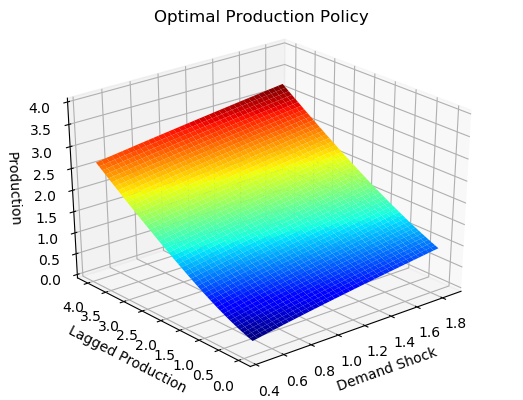

In [64]:
title = "Optimal Production Policy"
xlabel = "Demand Shock"
ylabel = "Lagged Production"
zlabel = "Production"
zlims = (0, 4)
PyPlot.surf(grids..., reshape(X, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_zlim](zlims)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

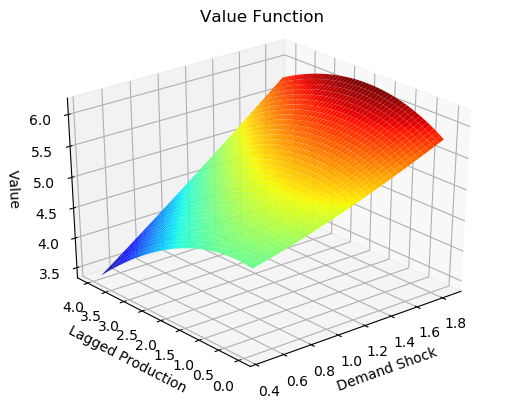

In [65]:
title = "Value Function"
zlabel = "Value"
PyPlot.surf(grids..., reshape(V, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)

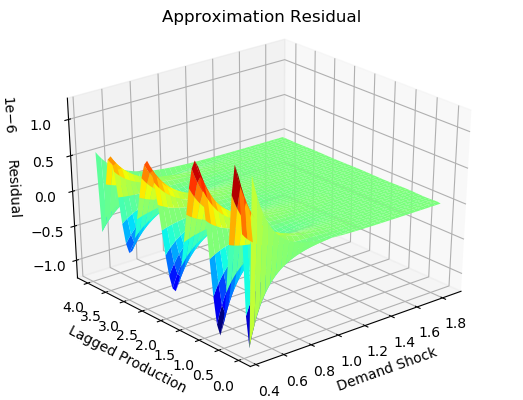

In [66]:
title = "Approximation Residual"
zlabel = "Residual"
PyPlot.surf(grids..., reshape(resid, grid_length...)', cmap=PyPlot.cm[:jet])
ax = PyPlot.gca()
ax[:set_xlabel](xlabel)
ax[:set_ylabel](ylabel)
ax[:set_zlabel](zlabel)
ax[:set_title](title, y=1.05)
ax[:view_init](ax[:elev], 230)
ax[:ticklabel_format](style="sci", axis="z", scilimits=(0,0))